### Кейс
Вы работаете в команде монетизации автоклассифайда. Команда раскатила новую ценовую политику на продавцов (листеров) в Новосибирске: повысили цены для всех на 10%. Основная гипотеза была в том, что вырастет месячный ARPPU (средняя выручка на одного платящего пользователя). Ожидаемое изменение ARPPU +/- 5%. Нововведение раскатили через АБ-тест, но период теста был ограничен, тест длился всего один месяц. Поэтому размер выборки в тесте тоже оказался ограничен.

Это первые тесты с ценами в Новосибирске, поэтому менеджер помимо ответа на основной вопрос (про рост ARPU на 5%) хочет найти дополнительные инсайты в реакции пользователей на новую ценовую политику.

Вам нужно проанализировать результаты теста, выполнив четыре задания, и помочь менеджеру лучше понять, как "зашли" новые цены в Новосибирске.

Данные представляют из себя таблицу с тратами пользователей (`revenue`) за период проведения теста. В таблице представлены только пользователи с тратами больше 0.

В колонке `group` показано, к какой группе относится пользователь:

`group` = 0 - контрольная группа со старыми ценами,

`group` = 1 - тестовая группа с новыми ценами.

### Задание 1. Размер эффекта (1/4)
Для начала попробуем определить размер эффекта. Для этого найдем несколько ключевых значений.

Найдите среднее значение revenue для группы 0.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

Используйте точку для разделения целой и дробной части.

### Задание 1. Размер эффекта (2/4)
Найдите среднее значение revenue для группы 1.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

Используйте точку для разделения целой и дробной части.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportion_confint

In [2]:
df = pd.read_csv("bootstrap_homework.csv")
df.head()

,passport_id,region,revenue,group
0,135342321,Новосибирск,320,0
1,142791180,Новосибирск,2173,1
2,123514803,Новосибирск,215,0
3,124568474,Новосибирск,1720,0
4,141887661,Новосибирск,645,0


In [3]:
describe_df = df.groupby("group", as_index=False).agg(
    mean_rev=("revenue", "mean"),
    std=("revenue", "std"),
    person_qty=("passport_id", "nunique"),
)
control_group_mean = describe_df[describe_df["group"] == 0].mean_rev.values[0]
test_group_mean = describe_df[describe_df["group"] == 1].mean_rev.values[0]

print(f"Средняя выручка в контрльной группе равна:{control_group_mean:0.1f}")
print(f"Средняя выручка в тестовой группе равна:{test_group_mean:0.1f}")

Средняя выручка в контрльной группе равна:1534.6
Средняя выручка в тестовой группе равна:1587.8


### Задание 1. Размер эффекта (3/4)
Рассчитайте абсолютный наблюдаемый эффект между двумя группами.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

Используйте точку для разделения целой и дробной части.

In [4]:
round(
    test_group_mean - control_group_mean,
    1,
)

53.2

### Задание 1. Размер эффекта (4/4)
Чему равен стандартизированный effect size Cohen D, найденный между группами, если std брать только по группе 0?

Введите ответ в поле ниже с точностью до трех знаков после запятой.

Используйте точку для разделения целой и дробной части.

Формула для расчета индекса d Коэна:

$$\Large d=\frac{M_{1}-M_{2}}{\sqrt{\frac{S_{1}^2+S_{1}^2}{2}}}$$

In [5]:
var_control_group = (
    describe_df[describe_df["group"] == 0]["std"].values[0] ** 2
)

cohen_d = (
    (control_group_mean - test_group_mean)
    / ((var_control_group + var_control_group) / 2) ** 0.5
    * -1
)

round(cohen_d, 3)

0.007

### Задание 2. Размер выборки (1/4)
Определим, какая выборка нам была бы нужна для детекции 5% относительного эффекта в средних между группами.

Рассчитайте размер выборки, необходимый для детекции 5% относительных процентов в двустороннем t-test с alpha = 0.05, power = 0.8. За основу для расчета нужных параметров (mean, lift, std) используйте данные по группе 0.

Введите ответ в виде целого числа поле ниже.

In [6]:
hist_data = df["revenue"][df["group"] == 0]
lift_1 = hist_data.mean() * (0.05)
std_1 = hist_data.std()
cohen_d_1 = lift_1 / std_1

sample_size_1 = round(
    tt_ind_solve_power(
        effect_size=cohen_d_1, alpha=0.05, power=0.8, nobs1=None, ratio=1
    )
)
print(
    "Для детекции 5% изменения средней с помощью t-test нужна выборка:",
    sample_size_1,
)

Для детекции 5% изменения средней с помощью t-test нужна выборка: 162949


### Задание 2. Размер выборки (2/4)
А какая выборка нам была бы нужна, если бы мы использовали критерий Манна-Уитни?

Попробуем рассчитать с помощью симуляции размер выборки, для того чтобы задетектить те же 5%, но с помощью критерия Манна-Уитни.

Перед стартом симуляции укажите:

```python
np.random.seed(1)
```


Массив для перебора размера выборок начните с 500 до 5000 с шагом 100:

```python
sample_size_list = np.arange(500, 5000, 100)
```

Введите ответ в виде целого числа поле ниже.



In [7]:
sample_size_list = np.arange(500, 5000, 100)
sample_size_list

array([ 500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500,
       1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600,
       2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700,
       3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800,
       4900])

In [8]:
def get_beta_many_mw_ab_tests(hist_data, rel_lift, sample_size, n_sim):
    """
    функция проводящая многократно Манна_Уитни тесты с заданными параметрами
    hist_data - исторические данные, которые используем для генерации выборок А и Б
    rel_lift - относительный рост средней, задаваемый для проверки мощности. Относительный MDE
    sample_size - размер выборки в тесте
    n_sim - кол-во симуляций для одного размера выборки
    output - возвращает alpha, beta и 95%-доверительные интервалы
    """
    aa_means_diff_list = []
    ab_means_diff_list = []
    aa_p_val_list = []
    ab_p_val_list = []

    for i in tqdm(range(n_sim), disable=True):
        sample_a_1 = np.random.choice(
            hist_data, size=sample_size
        )  # контрольная группа без эффекта
        sample_a_2 = np.random.choice(
            hist_data, size=sample_size
        )  # тестовая группа без эффекта
        sample_b = np.random.choice(hist_data, size=sample_size) * (
            1 + rel_lift
        )  # тестовая группа c эффектом

        aa_means_diff = sample_a_1.mean() - sample_a_2.mean()
        ab_means_diff = sample_a_1.mean() - sample_b.mean()
        aa_p_val = mannwhitneyu(sample_a_1, sample_a_2)[
            1
        ]  # применем MW для АА версии
        ab_p_val = mannwhitneyu(sample_a_1, sample_b)[1]  # применяем MW для AB

        aa_means_diff_list.append(aa_means_diff)
        ab_means_diff_list.append(ab_means_diff)
        aa_p_val_list.append(aa_p_val)
        ab_p_val_list.append(ab_p_val)

    alpha = np.sum(np.array(aa_p_val_list) < 0.05) / n_sim
    power = np.sum(np.array(ab_p_val_list) < 0.05) / n_sim

    alpha_ci = proportion_confint(
        np.sum(np.array(aa_p_val_list) < 0.05), n_sim, alpha=0.05
    )
    power_ci = proportion_confint(
        np.sum(np.array(ab_p_val_list) < 0.05), n_sim, alpha=0.05
    )

    output = {
        "alpha": alpha,
        "power": power,
        "alpha_ci": alpha_ci,
        "power_ci": power_ci,
    }

    return output

In [9]:
sample_size_list = np.arange(
    500, 5000, 100
)  # зададим линейное пространство размера выборок, по которому мы будем перебирать

mw_power_list = []
mw_lower_power_ci_list = []
mw_upper_power_ci_list = []

np.random.seed(1)
# прогоним циклом, где для каждого размера выборки мы численно находим мощность и другие параметры
for i in tqdm(sample_size_list):
    mw_output = get_beta_many_mw_ab_tests(hist_data, 0.05, i, 1000)

    mw_alpha = mw_output["alpha"]
    mw_power = mw_output["power"]
    mw_power_ci = mw_output["power_ci"]
    mw_power_list.append(mw_power)
    mw_lower_power_ci_list.append(mw_power_ci[0])
    mw_upper_power_ci_list.append(mw_power_ci[1])

  0%|          | 0/45 [00:00<?, ?it/s]

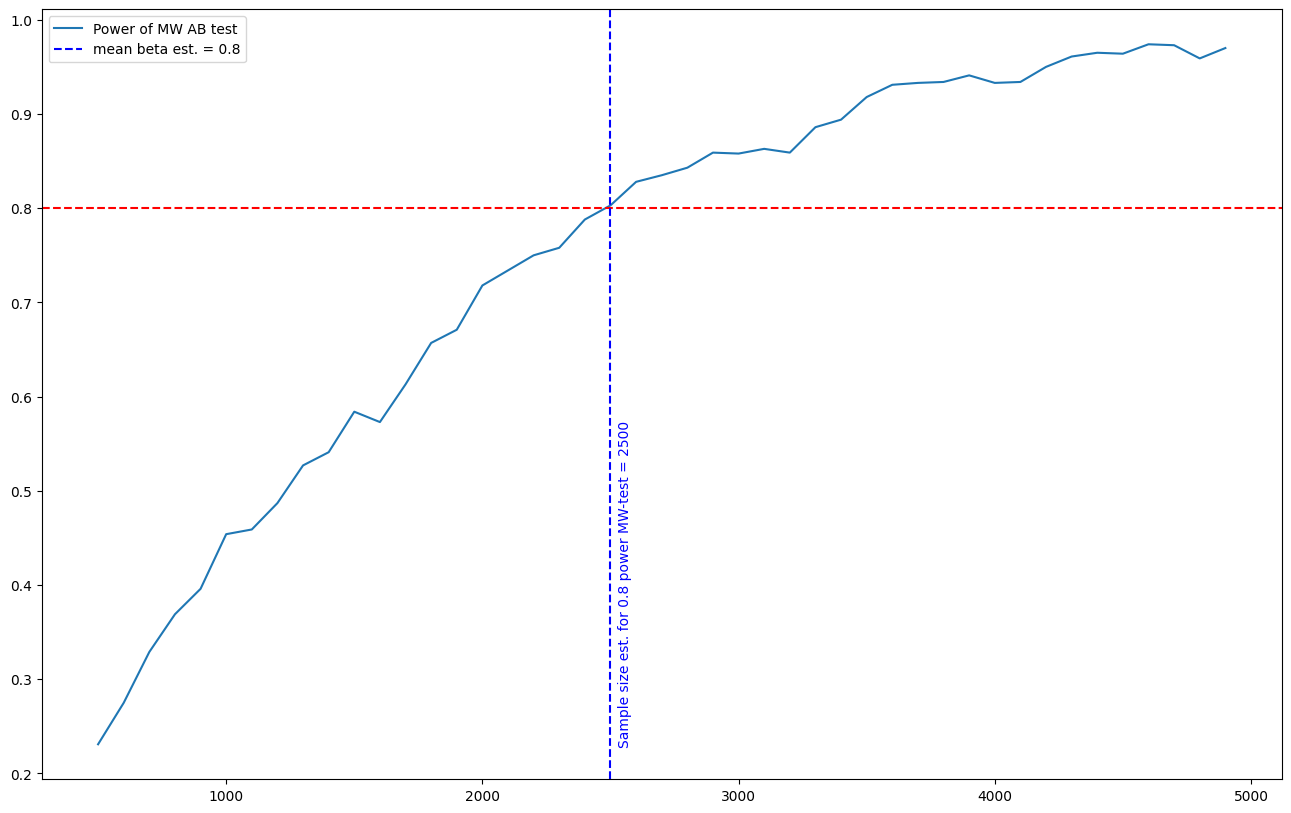

In [11]:
mw_power_est_index = np.argmax(np.array(mw_power_list) >= 0.8)

plt.figure(figsize=(16, 10))
sns.lineplot(x=sample_size_list, y=mw_power_list, label="Power of MW AB test")

plt.axhline(0.8, color="red", linestyle="--")
plt.axvline(
    sample_size_list[mw_power_est_index],
    color="blue",
    linestyle="--",
    label="mean beta est. = 0.8",
)
plt.text(
    sample_size_list[mw_power_est_index] + 30,
    np.min(mw_power_list),
    "Sample size est. for 0.8 power MW-test = {}".format(
        sample_size_list[mw_power_est_index]
    ),
    rotation="vertical",
    color="blue",
)

plt.legend()

### Задание 2. Размер выборки (3/4)
Хорошо, мы поняли какая выборка нужна была бы для детекции 5%, но наблюдаемый эффект у нас меньше относительного MDE. Интересно понять, какая выборка нам была бы нужна, чтобы задетектить MDE такого размера.

Рассчитайте размер выборки, необходимый для детекции наблюдаемого эффекта, найденного в задании 1, через двусторонний t-test. С альфа = 0.05 и мощностью 0.8. Выборка 50/50. Для определения cohen_D эффекта используйте std только по контрольной группе.

Введите ответ в виде целого числа поле ниже.

In [30]:
alpha = 0.05
power = 0.8

sample_size_test = np.ceil(
    tt_ind_solve_power(
        effect_size=cohen_d, alpha=alpha, power=power, nobs1=None, ratio=1
    )
)
print(
    f"Для детекции {round(cohen_d * 100, 1)}% изменения средней с помощью t-test нужна выборка:",
    sample_size_test,
)

Для детекции 0.7% изменения средней с помощью t-test нужна выборка: 338943.0


### Задание 2. Размер выборки (4/4)
Мы поняли, что наблюдаемый эффект меньше желаемого MDE, при этом и выборка у нас меньше нужного размера. Давайте посмотрим, какой MDE мы можем себе позволить на имеющейся выборке при проверке разницы средних через двусторонний t-test. Параметры дизайна теста те же самые.

Рассчитайте, какой абсолютный MDE вы можете себе позволить с датасетом имеющегося размера и std равным std в группе 0. 

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

Используйте точку для разделения целой и дробной части.



In [36]:
MDE = tt_ind_solve_power(
    effect_size=None,
    alpha=alpha,
    power=power,
    nobs1=describe_df.person_qty[0],
    ratio=1,
    alternative="two-sided",
)
round(MDE * describe_df["std"][0], 1)

244.9